In [ ]:
import os

json_file_path = "./Plant_Disease_Dataset_Unified"
print(os.path.exists(json_file_path))  # This should return True if the file exists


In [ ]:
!pip install opencv-python

In [ ]:
!pip install torch torchvision torchaudio

In [ ]:
!pip install segmentation-models-pytorch
!pip install segmentation-models-pytorch torch torchvision albumentations
!pip install albumentations

In [ ]:
import os
print(os.listdir())

In [ ]:
import torch
import os

print(os.listdir("./segment-anything"))
from segment_anything import sam_model_registry

# Load SAM model

sam_checkpoint = "segment-anything/sam_vit_h_4b8939.pth"  # Path to SAM weights model_type = "vit_h"  # Use "vit_b" for smaller models
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device)


In [ ]:
import os
import cv2
import torch
from torch.utils.data import Dataset
from torchvision import transforms

class PlantDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.mask_paths = []

        # Load all image and mask paths
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                mask_path = img_path.replace("images", "masks")  # Assuming masks are stored separately
                self.image_paths.append(img_path)
                self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]
    
        # Load image and mask
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert to RGB
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
    
        # Apply transformations
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']  # Already a tensor due to ToTensorV2()
            mask = augmented['mask']    # Already a tensor due to ToTensorV2()
    
        # Add channel dimension to mask
        mask = mask.unsqueeze(0)  # Shape: (1, H, W)
    
        return image, mask

In [ ]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(256, 256),  # Resize to 256x256
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # ImageNet normalization
    ToTensorV2(),
])

In [ ]:
from torch.utils.data import DataLoader

# Define dataset paths
train_dataset = PlantDiseaseDataset(root_dir="Plant_Disease_Dataset_Unified/train", transform=transform)
valid_dataset = PlantDiseaseDataset(root_dir="Plant_Disease_Dataset_Unified/valid", transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False)

In [ ]:
dataset = PlantDiseaseDataset(root_dir="Plant_Disease_Dataset_Unified/train", transform=transform)
image, mask = dataset[0]  # Get the first sample
print("Image shape:", image.shape)  # Should be (3, H, W)
print("Mask shape:", mask.shape)   # Should be (1, H, W)

In [ ]:
for images, masks in train_loader:
    print("Images shape:", images.shape)
    print("Masks shape:", masks.shape)
    break  # Stop after one batch

In [ ]:
import cv2
import numpy as np
from PIL import Image

def generate_mask(image_path, output_path):
    # Load an image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image at path: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize SAM predictor
    predictor.set_image(image)

    # Define a point prompt
    input_point = np.array([[100, 100]])  # Point on diseased region
    input_label = np.array([1])  # 1 for foreground

    # Generate mask
    masks, _, _ = predictor.predict(
        point_coords=input_point,
        point_labels=input_label,
        multimask_output=True,  # Enable multi-mask output
    )

    # Save the mask
    mask_image = Image.fromarray((masks[0] * 255).astype(np.uint8))
    mask_image.save(output_path)

# Example usage
try:
    generate_mask("path/to/image.jpg", "path/to/output/mask.png")
except FileNotFoundError as e:
    print(e)

In [ ]:
################################################ USING SAM ###################################################

In [ ]:
import os

print(os.listdir())

In [ ]:
!nvidia-smi


In [ ]:
import torch
print("Is CUDA available?", torch.cuda.is_available())
print("GPU Name:", torch)

In [ ]:
import torch
import os

print(os.listdir("./segment-anything"))
from segment_anything import sam_model_registry

# Load SAM model

sam_checkpoint = "./segment-anything/sam_vit_h_4b8939.pth"  # Path to SAM weights model_type = "vit_h"  # Use "vit_b" for smaller models
device = "cuda" if torch.cuda.is_available() else "cpu"

sam = sam_model_registry["vit_h"](checkpoint=sam_checkpoint)
sam.to(device)


In [ ]:
from segment_anything import SamPredictor, sam_model_registry
# sam = sam_model_registry["vit_h"](checkpoint="./segment-anything/sam_vit_h_4b8939.pth")
predictor = SamPredictor(sam)


In [ ]:
def get_diseased_boxes(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Heuristic for diseased regions (brown/dark)
    lower_brown = np.array([5, 50, 50])
    upper_brown = np.array([30, 255, 200])

    lower_black = np.array([0, 0, 0])
    upper_black = np.array([180, 255, 50])

    mask_brown = cv2.inRange(hsv, lower_brown, upper_brown)
    mask_black = cv2.inRange(hsv, lower_black, upper_black)
    combined_mask = cv2.bitwise_or(mask_brown, mask_black)

    # Find contours of diseased regions
    contours, _ = cv2.findContours(combined_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    boxes = []

    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if w * h > 100:  # Filter small noise
            boxes.append([x, y, x+w, y+h])  # Format: [x1, y1, x2, y2]

    if not boxes:
        raise ValueError("No diseased regions detected for box prompting.")

    return np.array(boxes)


In [ ]:
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def generate_mask(image_path, output_path):
    # Load an image
    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Could not load image at path: {image_path}")

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Initialize SAM predictor
    predictor.set_image(image)

    # Define a point prompt
# Inside generate_mask()

    boxes = get_diseased_boxes(image)
    masks, _, _ = predictor.predict(
        box=boxes[0],  # Use the first detected box
        multimask_output=True
    )
    
    best_mask = max(masks, key=lambda m: m.sum())

    # Save the mask
    mask_image = Image.fromarray((best_mask * 255).astype(np.uint8))
    mask_image.save(output_path)

    for box in boxes:
        x1, y1, x2, y2 = box
        cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.imshow(image)
    plt.title("Auto-detected Box Prompts for SAM")
    plt.axis("off")
    plt.show()



    # Show the image and the mask
    plt.imshow(image)
    plt.imshow(best_mask, alpha=0.5, cmap='jet')
    plt.title("Mask Overlay")
    plt.axis('off')
    plt.show()
    

# Example usage
try:
    generate_mask("./Plant_Disease_Dataset_Unified/train/images/Grape___Black_rot/00cab05d-e87b-4cf6-87d8-284f3ec99626___FAM_B.Rot 3244.jpg", "./Plant_Disease_Dataset_Unified/train/images/Grape___Black_rot/masks/00cab05d-e87b-4cf6-87d8-284f3ec99626___FAM_B.Rot 3244.png")
except FileNotFoundError as e:
    print(e)

In [ ]:
##############################################  USE UNET #############################

In [19]:
import os
import numpy as np
from glob import glob
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp


# ----------------- Dataset -----------------
class LeafSegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform  # Fix: make sure this is initialized

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_paths[idx]).convert("L")) / 255.0

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented["image"]
            mask = augmented["mask"]
        else:
            img = torch.tensor(img / 255.0, dtype=torch.float).permute(2, 0, 1)
            mask = torch.tensor(mask, dtype=torch.float).unsqueeze(0)

        return img, mask


# ----------------- Paths Matching -----------------
def get_valid_image_mask_pairs():
    # Only get images that have masks
    mask_paths = glob("./dataset/masks/*/*.png")
    image_base_path = "./Plant_Disease_Dataset_Unified/train/images"

    image_mask_pairs = []
    for mask_path in mask_paths:
        mask_name = os.path.splitext(os.path.basename(mask_path))[0]
        
        # Search for matching image in all subfolders
        matching_image = glob(f"{image_base_path}/*/{mask_name}.jpg")
        if matching_image:
            image_mask_pairs.append((matching_image[0], mask_path))
        else:
            print(f"[!] Image not found for mask: {mask_path}")

    return zip(*image_mask_pairs)


# ----------------- Training -----------------
def train_model():
    image_paths, mask_paths = get_valid_image_mask_pairs()
    image_paths, mask_paths = list(image_paths), list(mask_paths)

    if len(image_paths) == 0:
        raise RuntimeError("No valid image-mask pairs found.")

    print(f"[INFO] Total valid image-mask pairs: {len(image_paths)}")

    # Split dataset into train and validation
    split = int(0.8 * len(image_paths))
    train_imgs, val_imgs = image_paths[:split], image_paths[split:]
    train_masks, val_masks = mask_paths[:split], mask_paths[split:]

    # Apply transformations (data augmentation)
    train_tf = A.Compose([
        A.Resize(256, 256),
        A.Normalize(),
        ToTensorV2(),
    ])

    val_tf = A.Compose([
        A.Resize(128, 128),
        A.Normalize(),
        ToTensorV2(),
    ])

    # Create datasets and dataloaders
    train_ds = LeafSegmentationDataset(train_imgs, train_masks, train_tf)
    val_ds = LeafSegmentationDataset(val_imgs, val_masks, val_tf)

    train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_ds, batch_size=2, shuffle=False, num_workers=0)

    # Initialize U-Net model
    model = smp.Unet(
        encoder_name="resnet34",
        encoder_weights="imagenet",
        in_channels=3,
        classes=1,
    )
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    # Loss function and optimizer
    loss_fn = smp.losses.DiceLoss(mode="binary")
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    # Training loop
    for epoch in range(5):
        model.train()
        epoch_loss = 0
        for imgs, masks in tqdm(train_loader, desc=f"Epoch {epoch + 1}"):
            imgs, masks = imgs.to(device), masks.to(device)
            preds = model(imgs)
            loss = loss_fn(preds, masks)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        print(f"Epoch {epoch + 1} Loss: {epoch_loss / len(train_loader):.4f}")

    # Save the model
    torch.save(model.state_dict(), "pretrained_unet_leaf.pth")


# ----------------- Prediction -----------------
def predict(image_path, model_path="pretrained_unet_leaf.pth", save_path=None):
    tf = A.Compose([
        A.Resize(256, 256),
        A.Normalize(),
        ToTensorV2(),
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    image = np.array(Image.open(image_path).convert("RGB"))
    input_tensor = tf(image=image)["image"].unsqueeze(0).to(device)

    model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=3, classes=1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    with torch.no_grad():
        pred = model(input_tensor)[0, 0].cpu().numpy()
        mask = (pred > 0.5).astype(np.uint8) * 255

    if save_path:
        Image.fromarray(mask).save(save_path)
        print(f"Saved predicted mask to {save_path}")

    # Visualize
    overlay = image.copy()
    overlay[mask == 255] = [255, 0, 0]  # Red overlay

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Original")
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(overlay)
    plt.axis("off")
    plt.show()


# ----------------- Run Training -----------------
train_model()

# ----------------- Run Prediction Example -----------------
# predict("Plant_Disease_Dataset_Unified/train/images/Apple___Apple_scab/<your_file>.JPG", save_path="output_mask.png")


[INFO] Total valid image-mask pairs: 108


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:11<00:00,  3.64it/s]


Epoch 1 Loss: 0.9270


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:12<00:00,  3.33it/s]


Epoch 2 Loss: 0.8873


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:13<00:00,  3.26it/s]


Epoch 3 Loss: 0.8519


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:14<00:00,  3.06it/s]


Epoch 4 Loss: 0.8050


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████████████████████| 43/43 [00:13<00:00,  3.26it/s]

Epoch 5 Loss: 0.7590


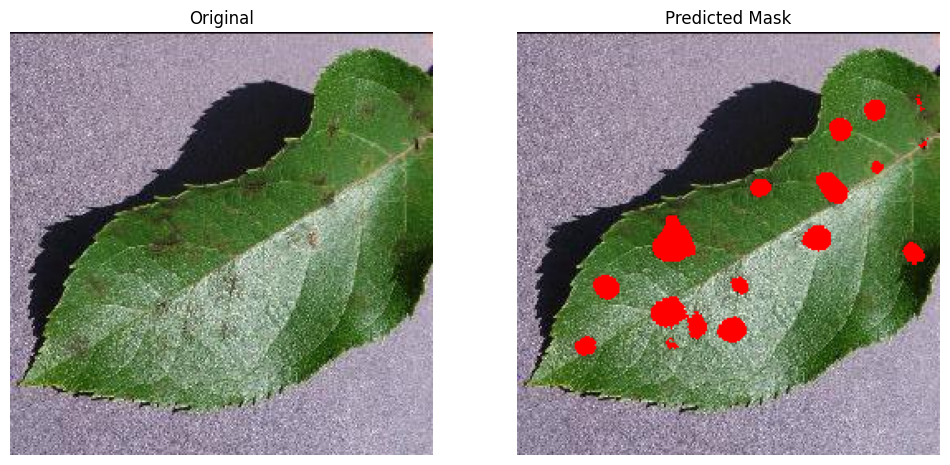

In [20]:

# Example prediction (adjust path if needed)
image_path = r"./Plant_Disease_Dataset_Unified/train/images/Apple___Apple_scab/76eca386-c7c1-4807-ae27-13c793d06e02___FREC_Scab 3272_90deg.JPG"

predict(image_path)


In [ ]:
import os

image_path = "./Plant_Disease_Dataset_Unified/train/images/Apple___Apple_scab/74dfd7d6-e78e-47d9-8530-35acab5cd01f___JR_FrgE.S 3027_90deg.jpg"
if os.path.exists(image_path):
    print(f"File exists: {image_path}")
else:
    print(f"File does not exist at: {image_path}")
    files = os.listdir("./Plant_Disease_Dataset_Unified/train/images/Apple___Apple_scab")
    print("Files in folder:")
    for f in files:
        print(f)


In [ ]:
import os
import numpy as np
from PIL import Image
from glob import glob
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp

# ----------------- Prediction -----------------
def predict_and_save_mask(image_path, model_path="pretrained_unet_leaf.pth", save_path=None):
    tf = A.Compose([
        A.Resize(256, 256),
        A.Normalize(),
        ToTensorV2(),
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    image = np.array(Image.open(image_path).convert("RGB"))
    input_tensor = tf(image=image)["image"].unsqueeze(0).to(device)

    model = smp.Unet("resnet34", encoder_weights="imagenet", in_channels=3, classes=1).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    with torch.no_grad():
        pred = model(input_tensor)[0, 0].cpu().numpy()
        mask = (pred > 0.5).astype(np.uint8) * 255

    if save_path:
        Image.fromarray(mask).save(save_path)
        print(f"Saved predicted mask to {save_path}")

    return mask


# ----------------- Generate Masks for Images Without Masks -----------------
def generate_masks_for_images_without_masks(image_dir, mask_dir, output_mask_dir, model_path="pretrained_unet_leaf.pth"):
    # Get list of images and their corresponding masks
    image_paths = glob(os.path.join(image_dir, "**", "*.jpg"), recursive=True)
    mask_paths = glob(os.path.join(mask_dir, "**", "*.png"), recursive=True)
    mask_names = [os.path.splitext(os.path.basename(mask_path))[0] for mask_path in mask_paths]

    # Loop through all images
    for image_path in image_paths:
        mask_name = os.path.splitext(os.path.basename(image_path))[0]

        # Check if this image has a corresponding mask
        if mask_name not in mask_names:
            # If no mask exists, generate the mask
            print(f"[INFO] Generating mask for {image_path}")

            # Get the class name (assumes class name is the immediate subdirectory of the image)
            class_name = os.path.basename(os.path.dirname(image_path))

            # Create corresponding directory for predicted masks
            class_output_dir = os.path.join(output_mask_dir, class_name)
            os.makedirs(class_output_dir, exist_ok=True)

            # Save the predicted mask in the class-specific directory
            generated_mask_path = os.path.join(class_output_dir, f"{mask_name}_predicted.png")
            predict_and_save_mask(image_path, model_path, save_path=generated_mask_path)
        else:
            print(f"[INFO] Mask already exists for {image_path}")


# ----------------- Run Prediction for All Images Without Masks -----------------
image_dir = "./Plant_Disease_Dataset_Unified/train/images"
mask_dir = "./dataset/masks"
output_mask_dir = "./predicted_masks"  # Directory for predicted masks

generate_masks_for_images_without_masks(image_dir, mask_dir, output_mask_dir, model_path="pretrained_unet_leaf.pth")


[INFO] Displaying images and predicted masks for class: app.py


<Figure size 1500x500 with 0 Axes>

[INFO] Displaying images and predicted masks for class: Apple___Apple_scab


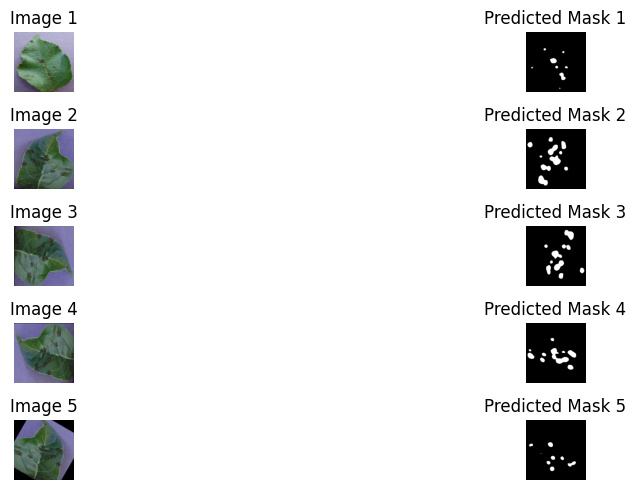

[INFO] Displaying images and predicted masks for class: Apple___Black_rot


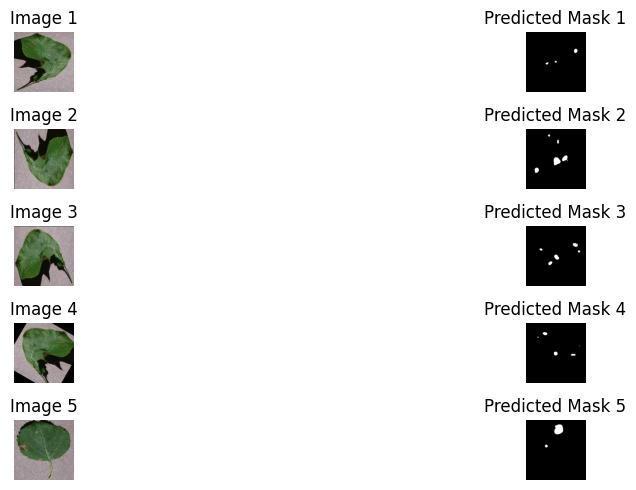

[INFO] Displaying images and predicted masks for class: Apple___Cedar_apple_rust


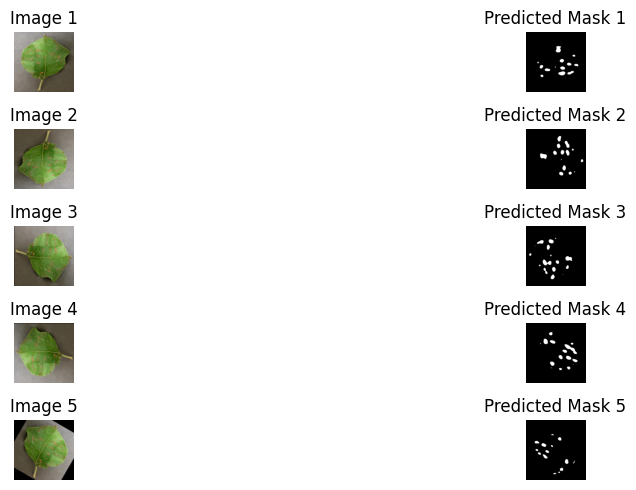

[INFO] Displaying images and predicted masks for class: Apple___healthy
[!] Number of images and masks don't match for class: Apple___healthy
[INFO] Displaying images and predicted masks for class: Blueberry___healthy
[!] Number of images and masks don't match for class: Blueberry___healthy
[INFO] Displaying images and predicted masks for class: Cherry_(including_sour)___healthy
[!] Number of images and masks don't match for class: Cherry_(including_sour)___healthy
[INFO] Displaying images and predicted masks for class: Cherry_(including_sour)___Powdery_mildew
[!] Number of images and masks don't match for class: Cherry_(including_sour)___Powdery_mildew
[INFO] Displaying images and predicted masks for class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
[!] Number of images and masks don't match for class: Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot
[INFO] Displaying images and predicted masks for class: Corn_(maize)___Common_rust_
[!] Number of images and masks don't match

<Figure size 1500x500 with 0 Axes>

[INFO] Displaying images and predicted masks for class: Grape___Black_rot
[!] Number of images and masks don't match for class: Grape___Black_rot
[INFO] Displaying images and predicted masks for class: Grape___Esca_(Black_Measles)
[!] Number of images and masks don't match for class: Grape___Esca_(Black_Measles)
[INFO] Displaying images and predicted masks for class: Grape___healthy
[!] Number of images and masks don't match for class: Grape___healthy
[INFO] Displaying images and predicted masks for class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
[!] Number of images and masks don't match for class: Grape___Leaf_blight_(Isariopsis_Leaf_Spot)
[INFO] Displaying images and predicted masks for class: Orange___Haunglongbing_(Citrus_greening)
[!] Number of images and masks don't match for class: Orange___Haunglongbing_(Citrus_greening)
[INFO] Displaying images and predicted masks for class: Peach___Bacterial_spot
[!] Number of images and masks don't match for class: Peach___Bacterial_spot


In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import albumentations as A
from albumentations.pytorch import ToTensorV2
import segmentation_models_pytorch as smp


# ----------------- Load and Display Actual Image and Predicted Mask -----------------
def show_images_and_masks(image_dir, output_mask_dir, num_images_per_class=5):
    # Get list of all image classes
    class_names = [os.path.basename(class_dir) for class_dir in glob(os.path.join(image_dir, "*"))]

    for class_name in class_names:
        print(f"[INFO] Displaying images and predicted masks for class: {class_name}")
        
        # Get image paths for the current class
        image_paths = glob(os.path.join(image_dir, class_name, "*.jpg"))
        predicted_mask_paths = glob(os.path.join(output_mask_dir, class_name, "*.png"))
        
        # Limit to a specific number of images per class
        image_paths = image_paths[:num_images_per_class]
        predicted_mask_paths = predicted_mask_paths[:num_images_per_class]

        # Ensure that there are matching images and masks
        if len(image_paths) != len(predicted_mask_paths):
            print(f"[!] Number of images and masks don't match for class: {class_name}")
            continue

        # Show the images and predicted masks side by side
        plt.figure(figsize=(15, 5))
        
        for idx, (img_path, mask_path) in enumerate(zip(image_paths, predicted_mask_paths)):
            image = np.array(Image.open(img_path).convert("RGB"))
            mask = np.array(Image.open(mask_path))

            plt.subplot(len(image_paths), 2, 2*idx+1)
            plt.imshow(image)
            plt.title(f"Image {idx+1}")
            plt.axis("off")

            plt.subplot(len(image_paths), 2, 2*idx+2)
            plt.imshow(mask, cmap="gray")
            plt.title(f"Predicted Mask {idx+1}")
            plt.axis("off")
        
        plt.tight_layout()
        plt.show()


# ----------------- Run Display Function -----------------
image_dir = "./Plant_Disease_Dataset_Unified/train/images"
output_mask_dir = "./predicted_masks"

show_images_and_masks(image_dir, output_mask_dir, num_images_per_class=5)
